In [2]:
# must go first 
%matplotlib inline 
%config InlineBackend.figure_format='retina'

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context("poster", font_scale=1.3)
import folium
#pip install folium

# system packages 
import os, sys
import warnings
warnings.filterwarnings('ignore')

# basic wrangling 
import numpy as np
import pandas as pd

# eda tools 
import pivottablejs
import missingno as msno
import pandas_profiling

# File with functions from prior notebook(s)
sys.path.append('../../scripts/')
from aqua_helper import time_slice, country_slice, time_series, simple_regions, subregion, variable_slice

# Update matplotlib defaults to something nicer 
mpl_update = {'font.size':16,
              'xtick.labelsize':14,
              'ytick.labelsize':14,
              'figure.figsize':[12.0,8.0],
              'axes.color_cycle':['#0055A7', '#2C3E4F', '#26C5ED', '#00cc66', '#D34100', '#FF9700','#091D32'], 
              'axes.labelsize':20,
              'axes.labelcolor':'#677385',
              'axes.titlesize':20,
              'lines.color':'#0055A7',
              'lines.linewidth':3,
              'text.color':'#677385'}
mpl.rcParams.update(mpl_update)

In [3]:
data = pd.read_csv('aquastat.csv.gzip', compression='gzip')

In [5]:
data.region = data.region.apply(lambda x: simple_regions[x])

# 数据质量评估和分析



### By variable

In [6]:
recent = time_slice(data, '2013-2017')

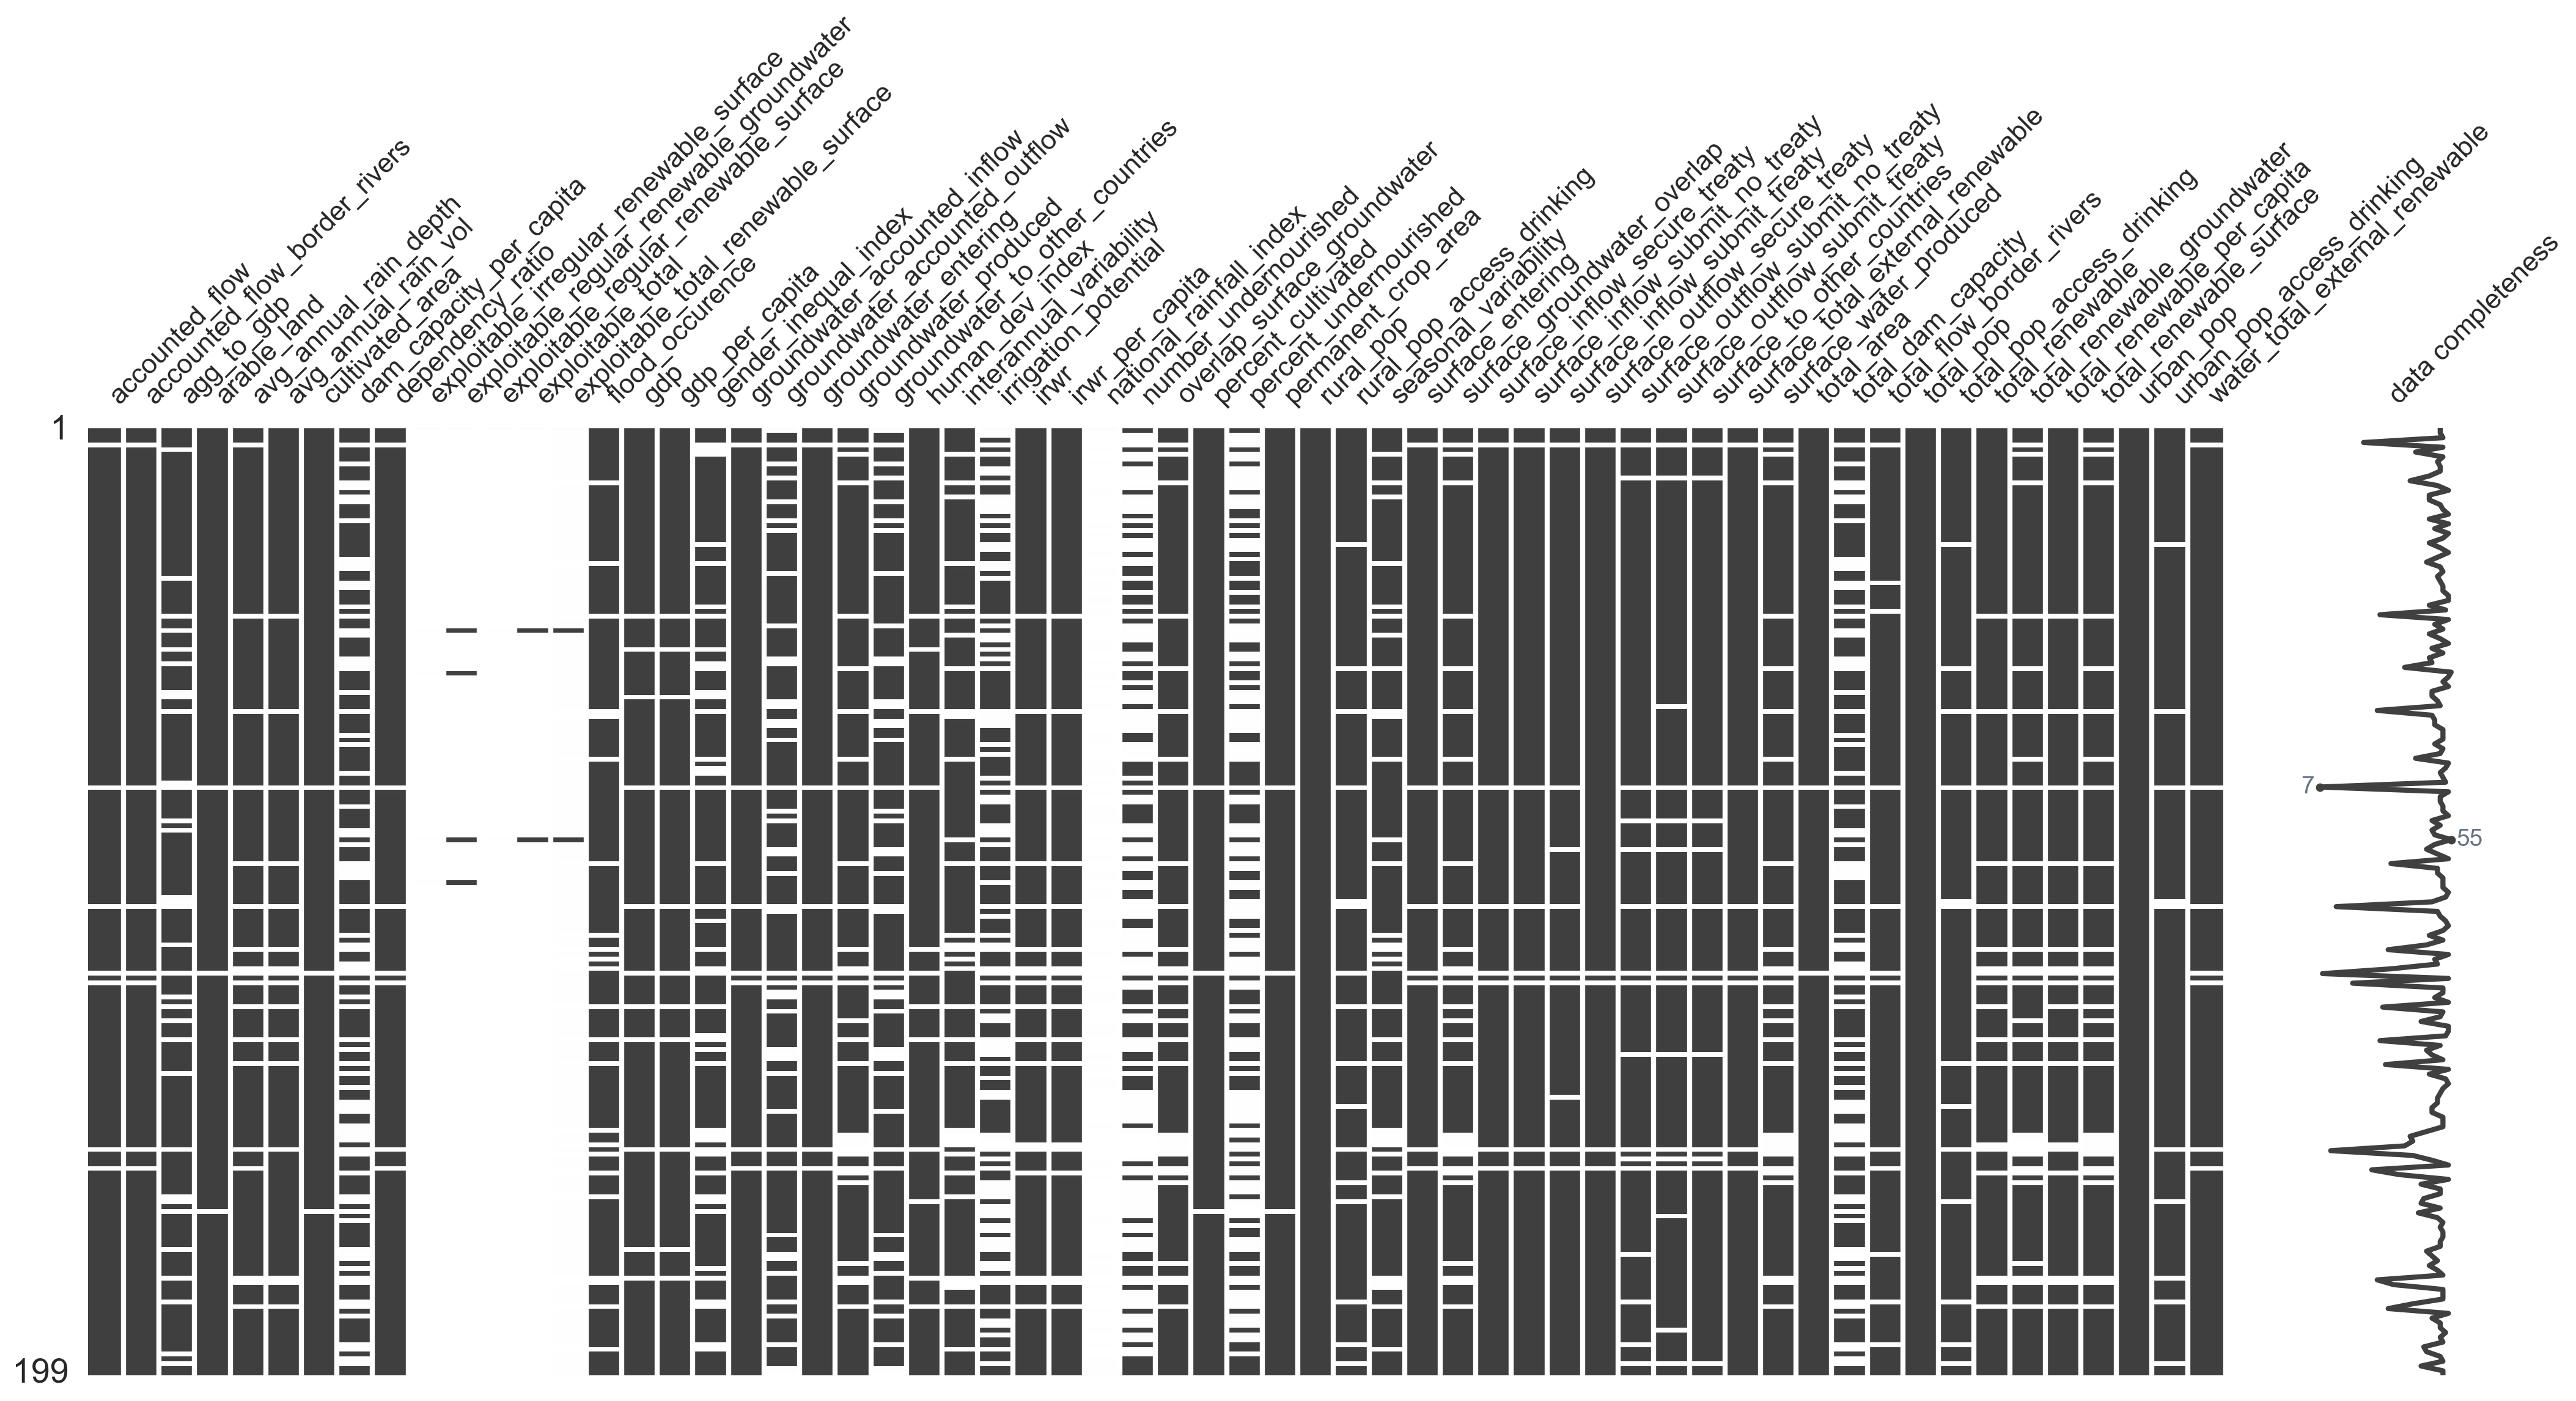

In [8]:
msno.matrix(recent, labels=True)

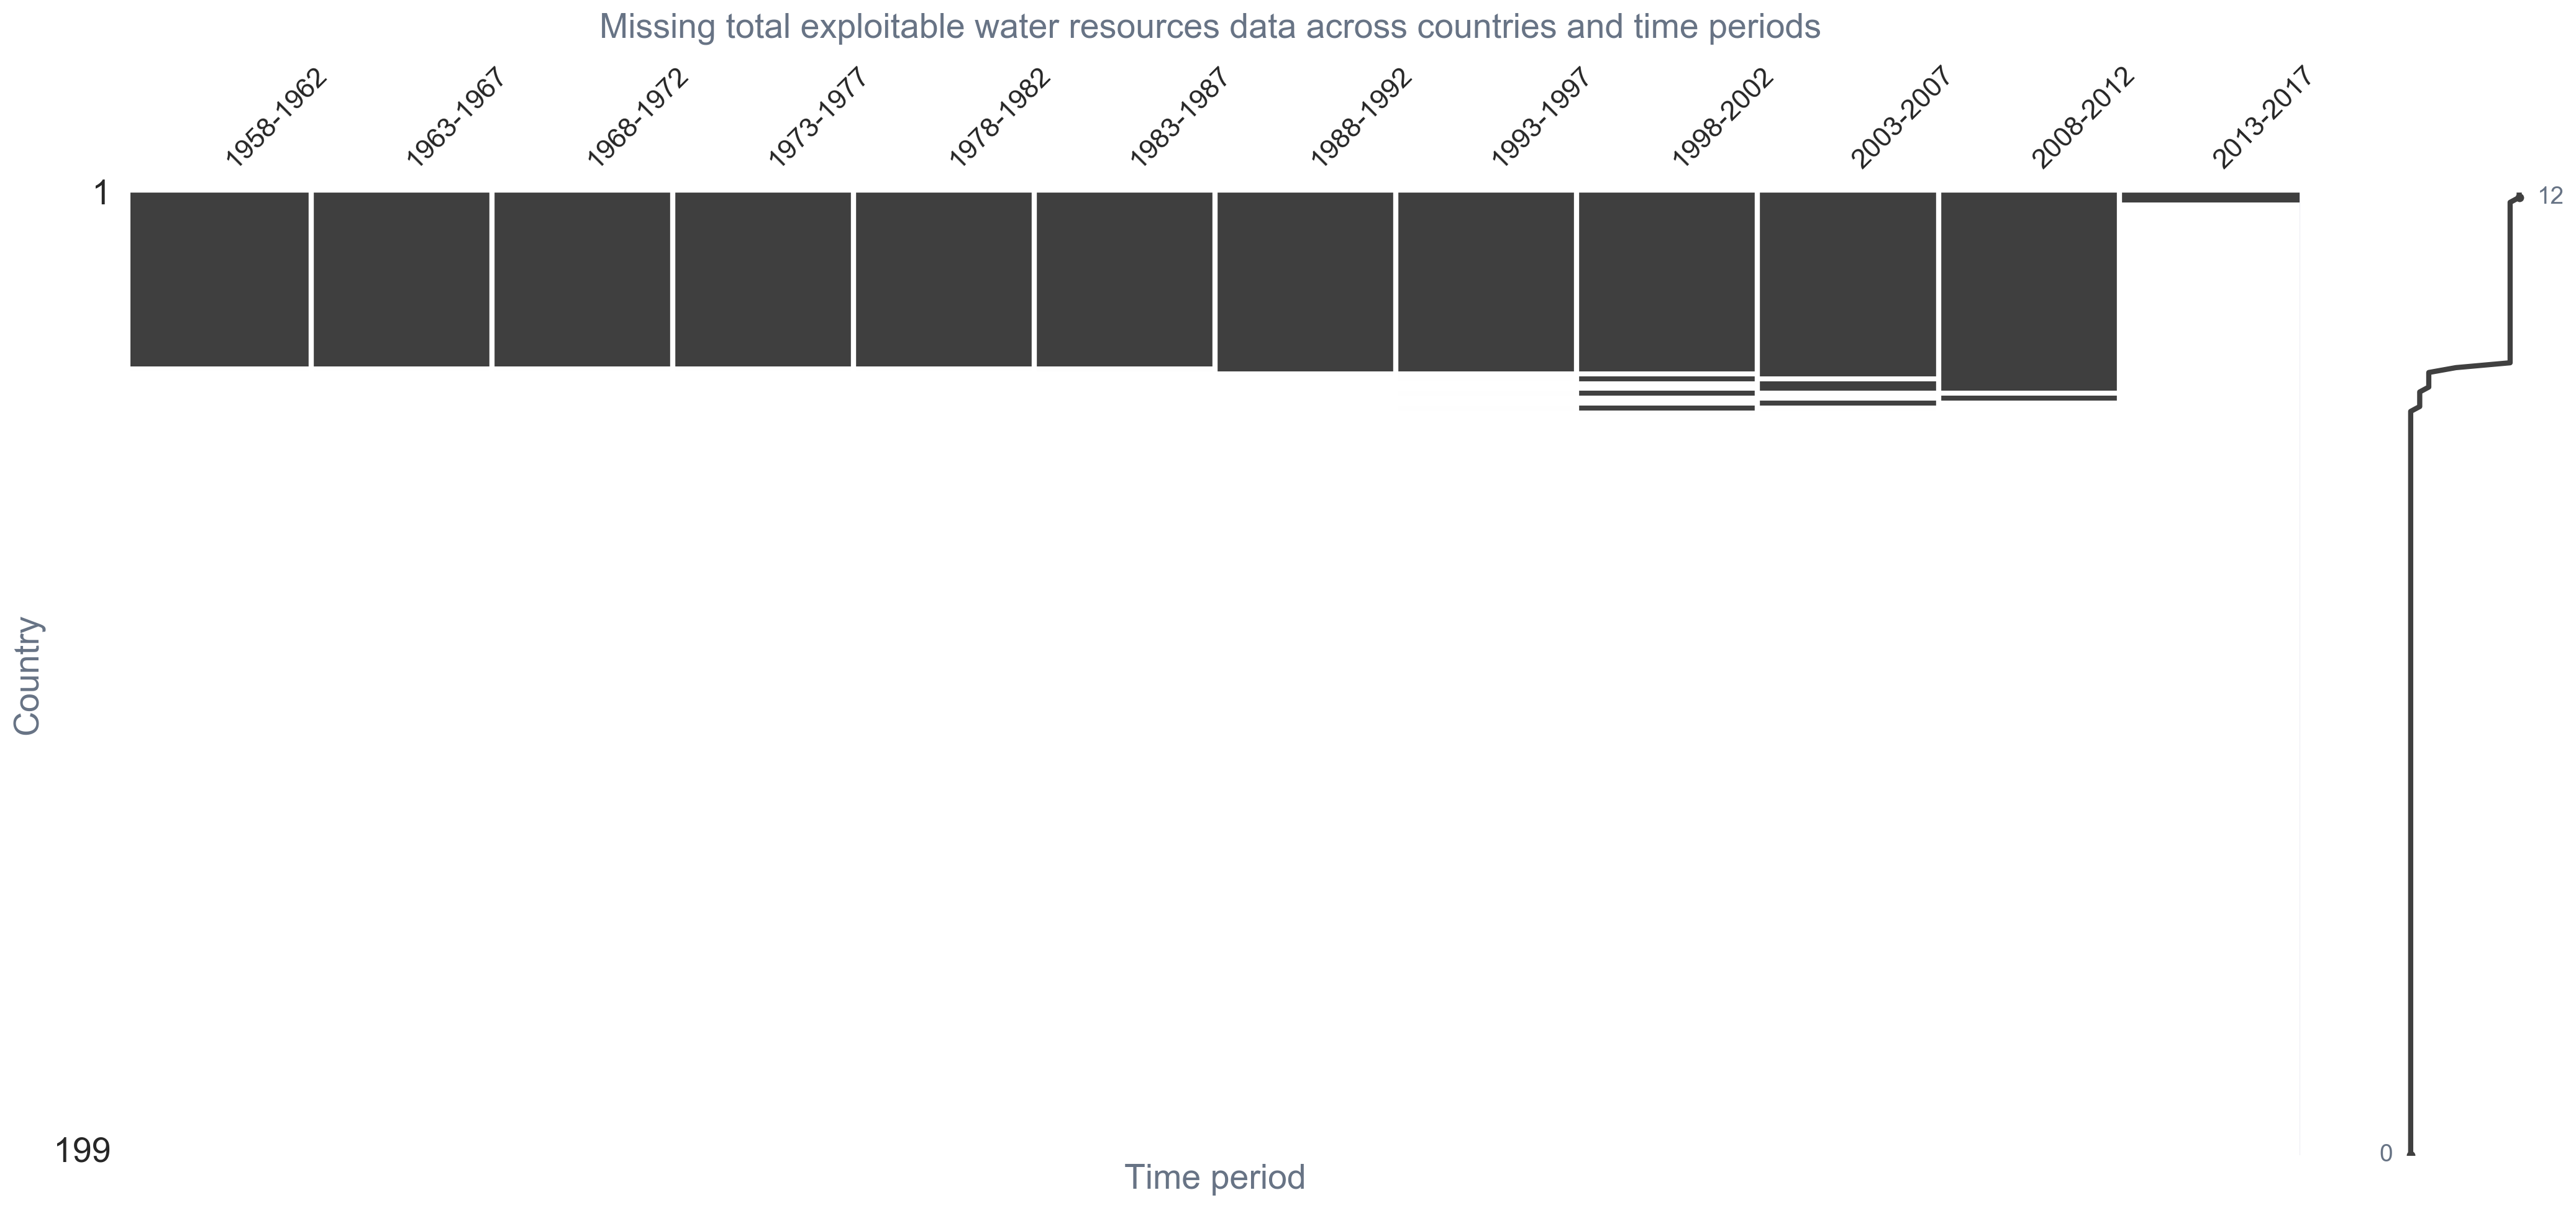

In [9]:
#Total exploitable water resources 水资源总量
msno.matrix(variable_slice(data, 'exploitable_total'), inline=False, sort='descending');
plt.xlabel('Time period');
plt.ylabel('Country');
plt.title('Missing total exploitable water resources data across countries and time periods \n \n \n \n');

只有一小部分国家报告了可利用的水资源总量，这些国家中只有极少数国家拥有最近一段时间的数据。 

我们将删除该变量，因为这么少的数据点会导致很多问题。 

In [10]:
data = data.loc[~data.variable.str.contains('exploitable'),:]

#### Deep dive: National rainfall index 

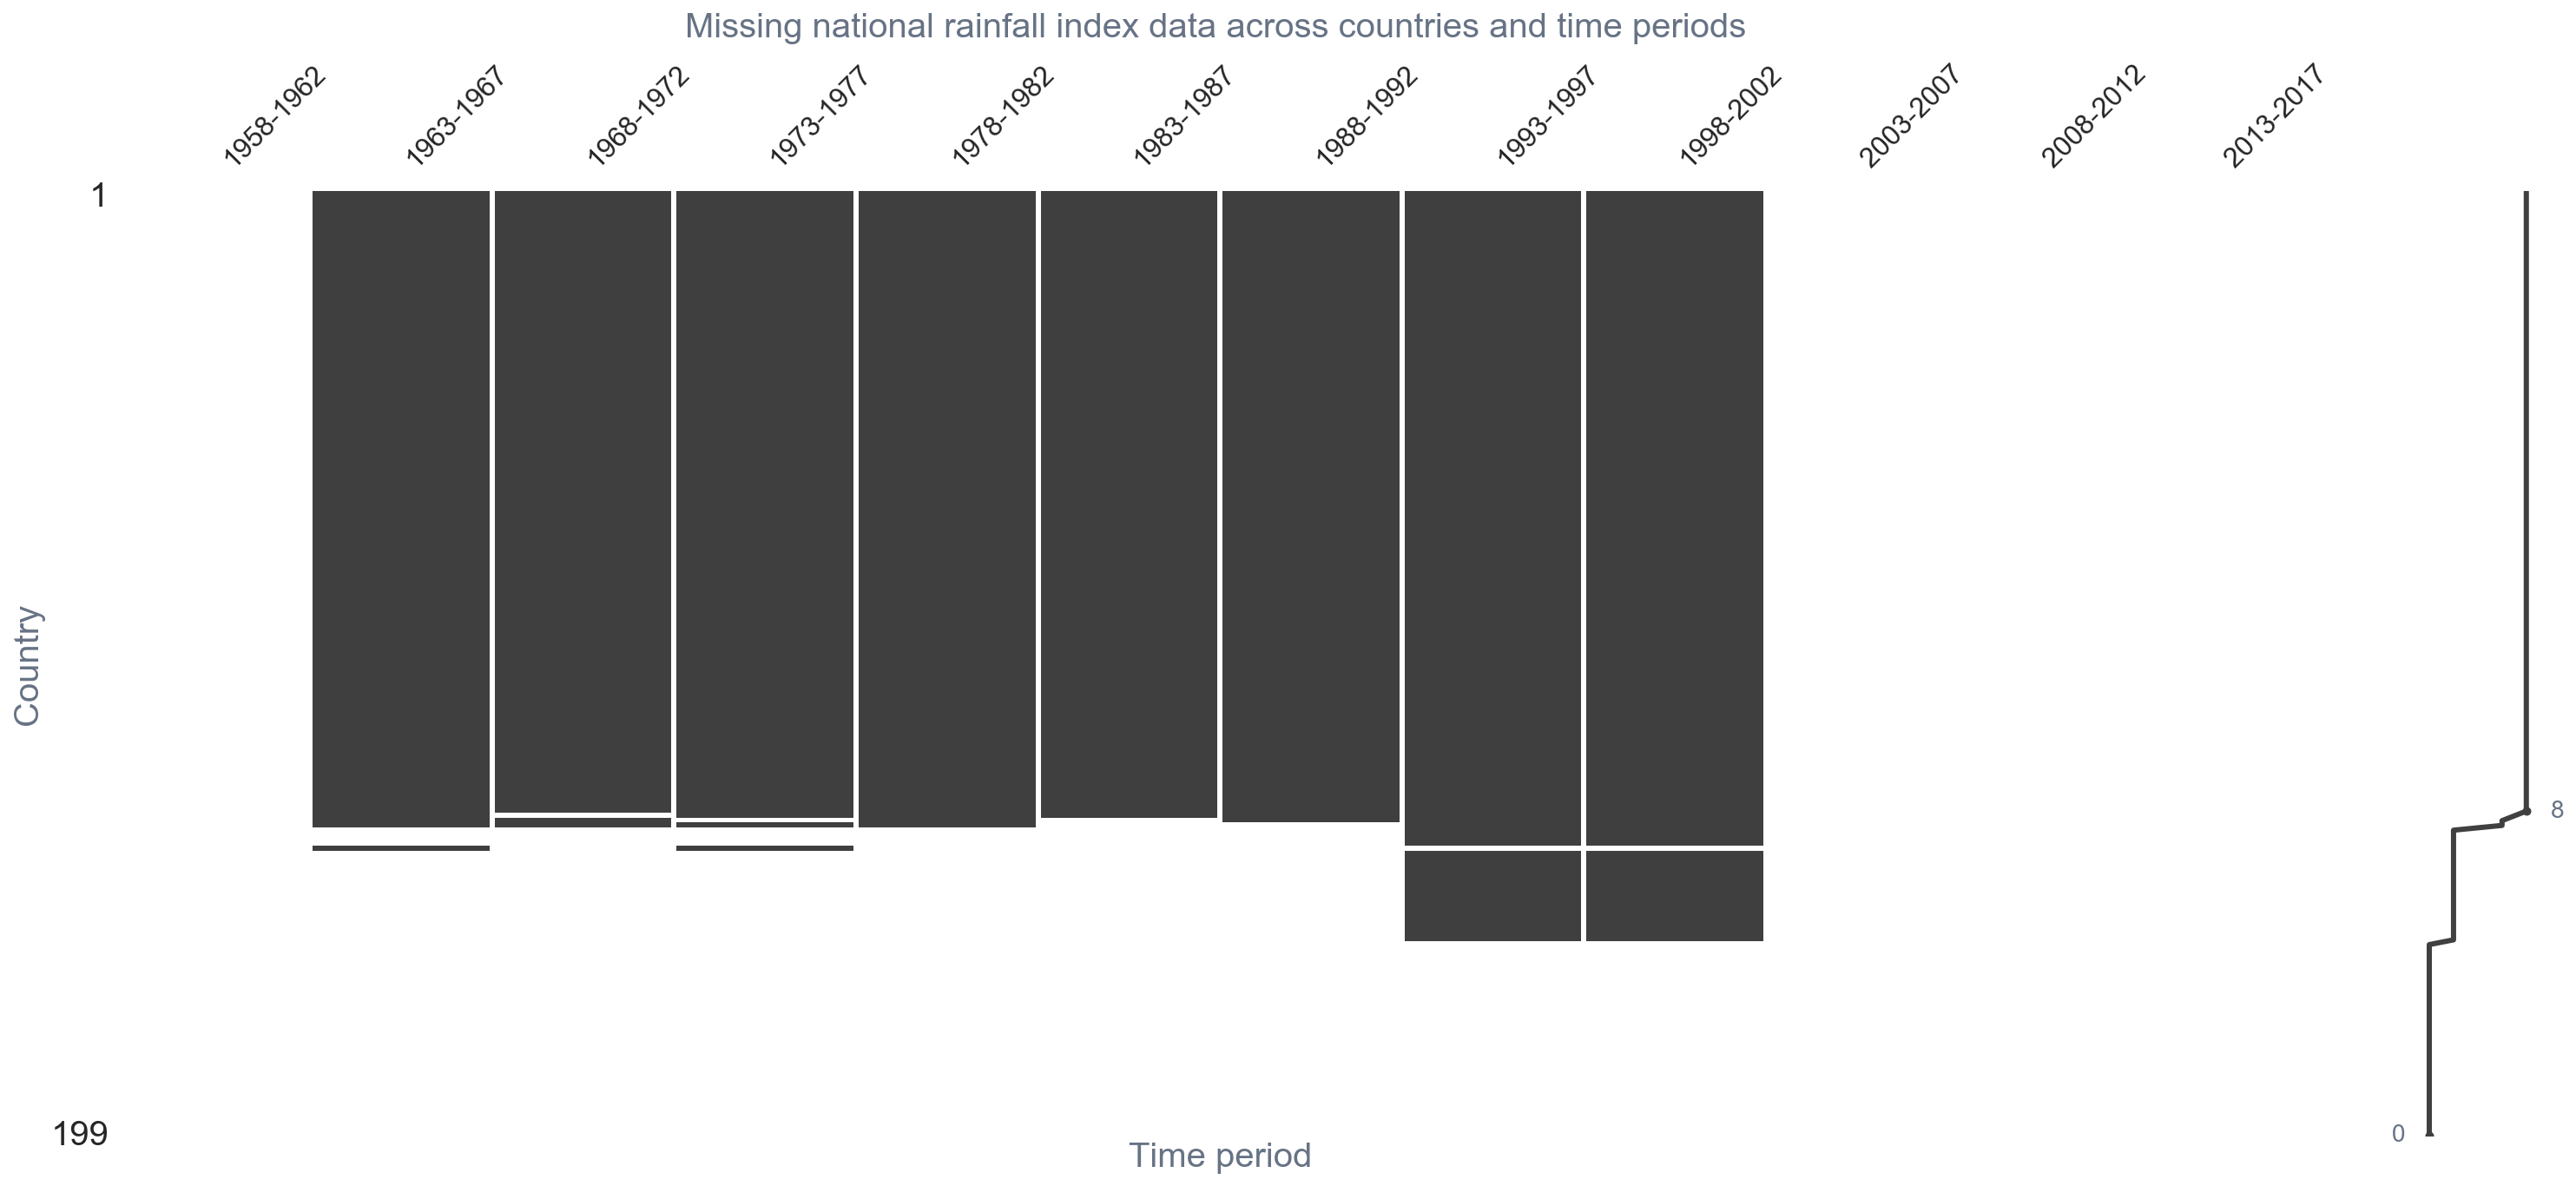

In [27]:
#national_rainfall_index 全国降水指数（NRI）（毫米/年)
msno.matrix(variable_slice(data, 'national_rainfall_index'), 
            inline=False, sort='descending');
plt.xlabel('Time period');
plt.ylabel('Country');
plt.title('Missing national rainfall index data across countries and time periods \n \n \n \n');

全国降雨指数在2002以后不再报告。

In [28]:
data = data.loc[~(data.variable=='national_rainfall_index')]

### By country

Let's look at North America only.

In [11]:
north_america = subregion(data, 'North America')

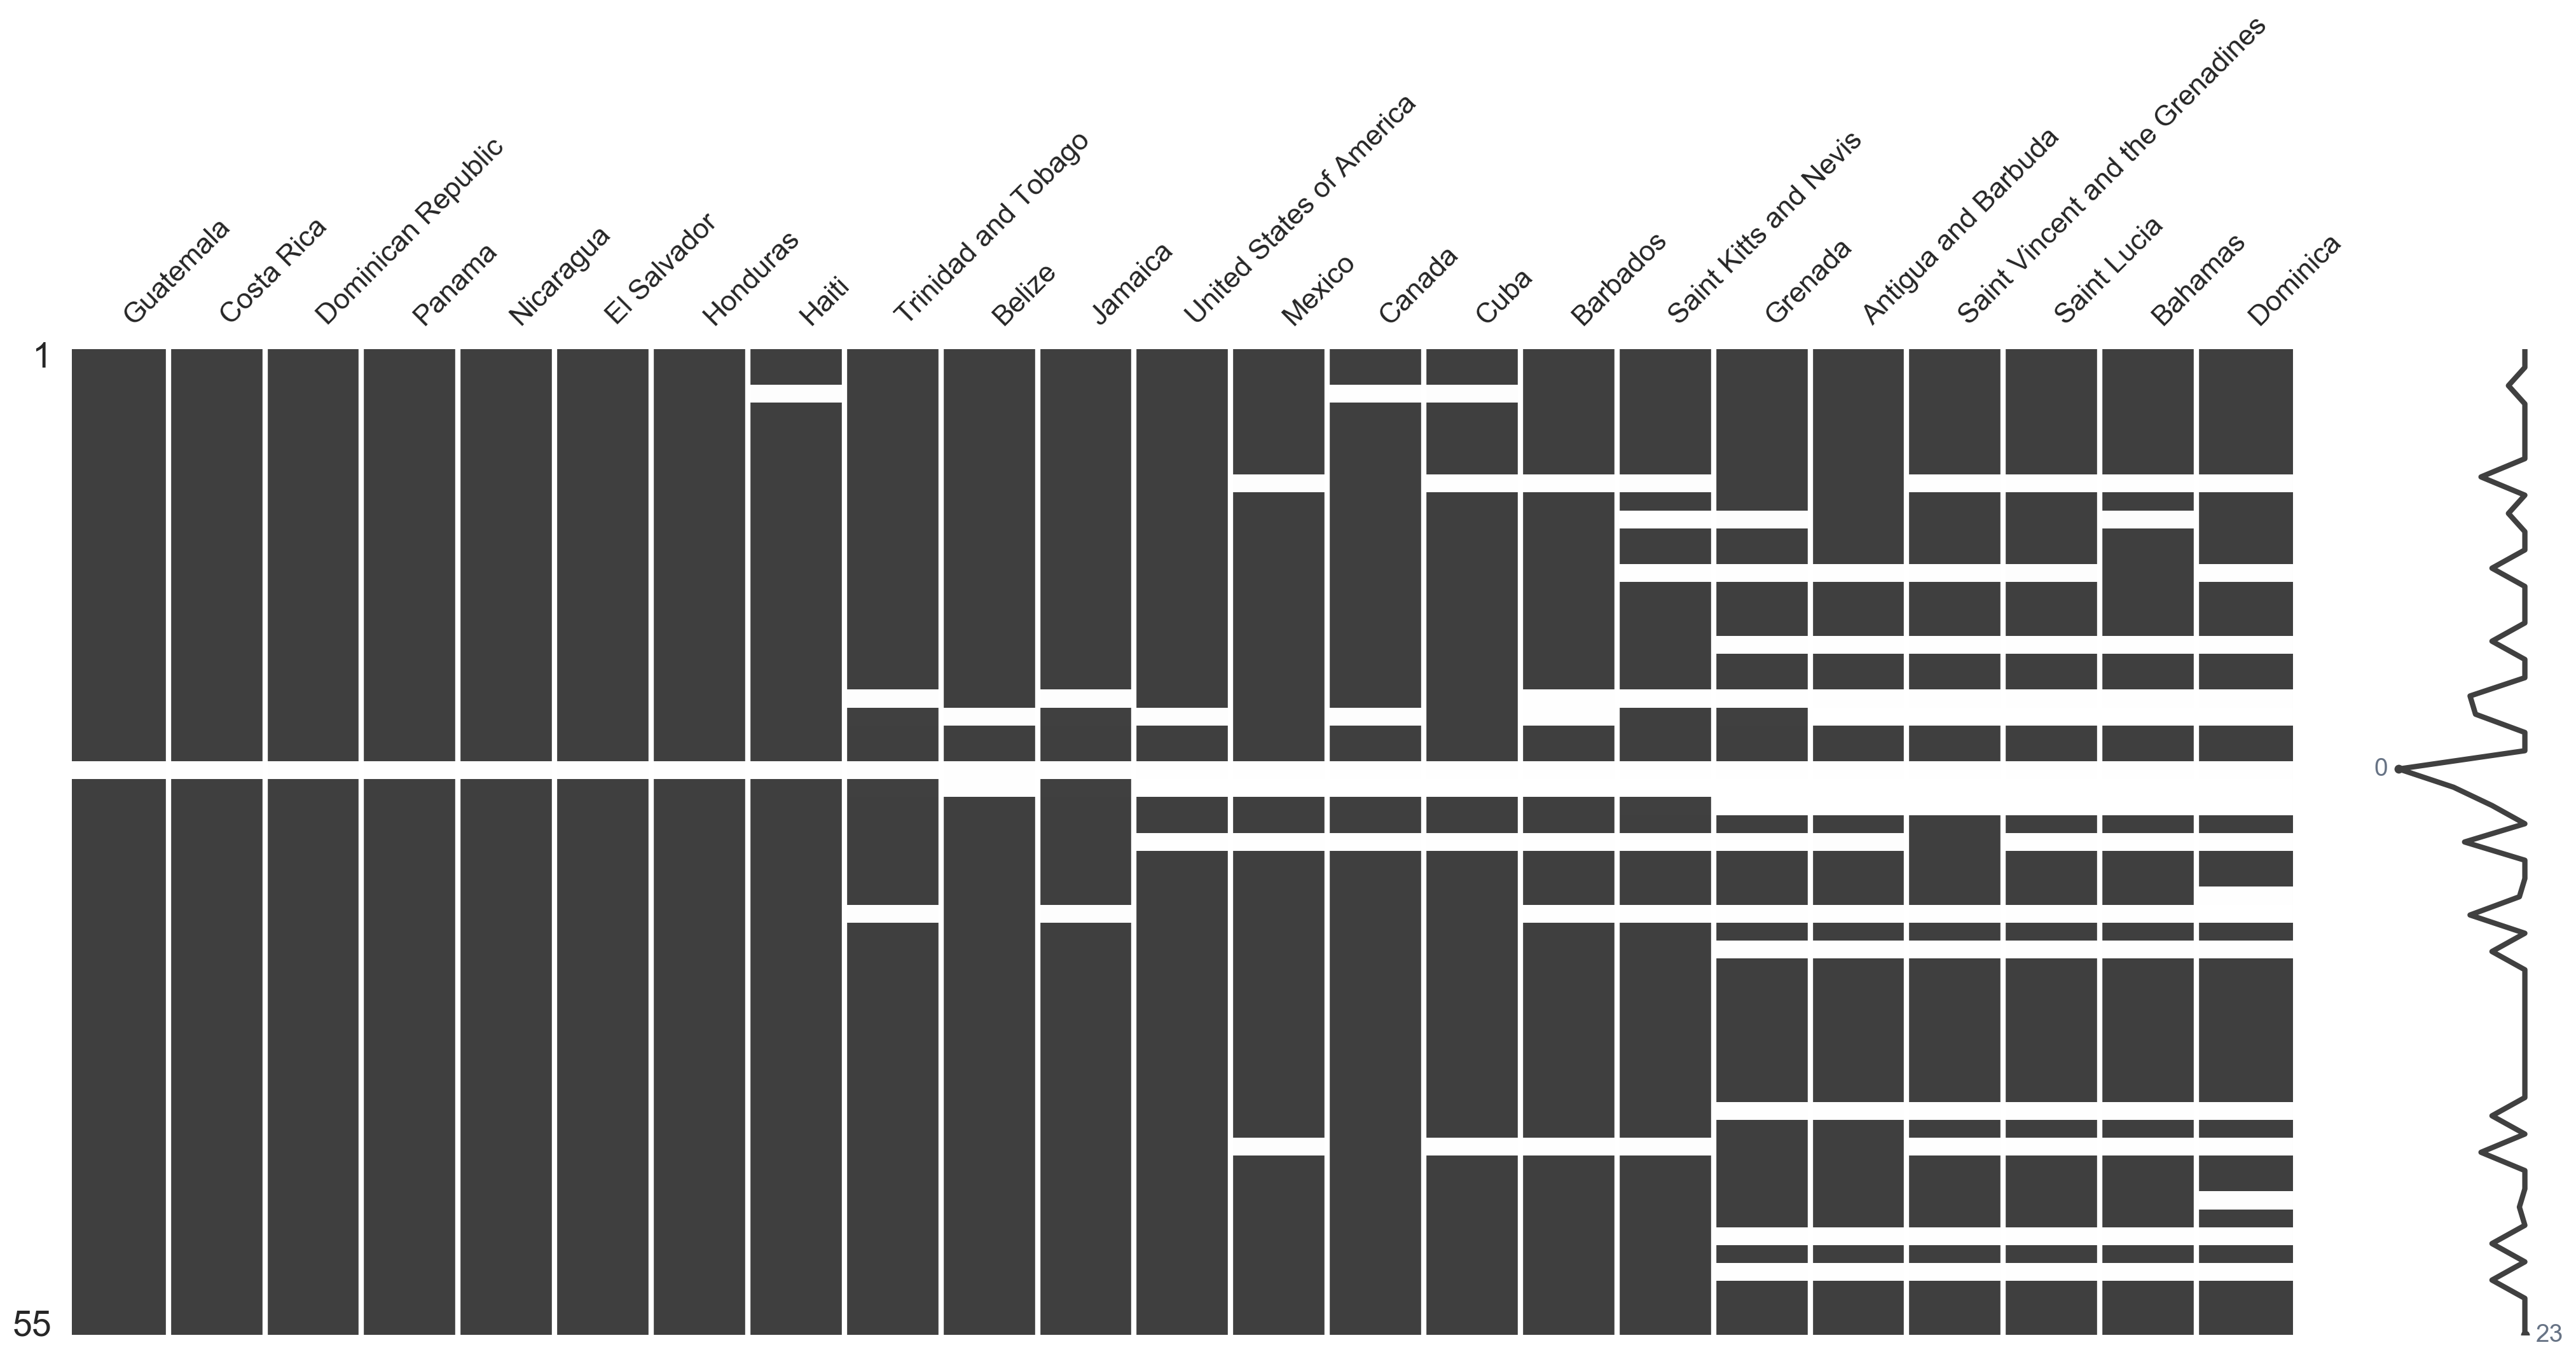

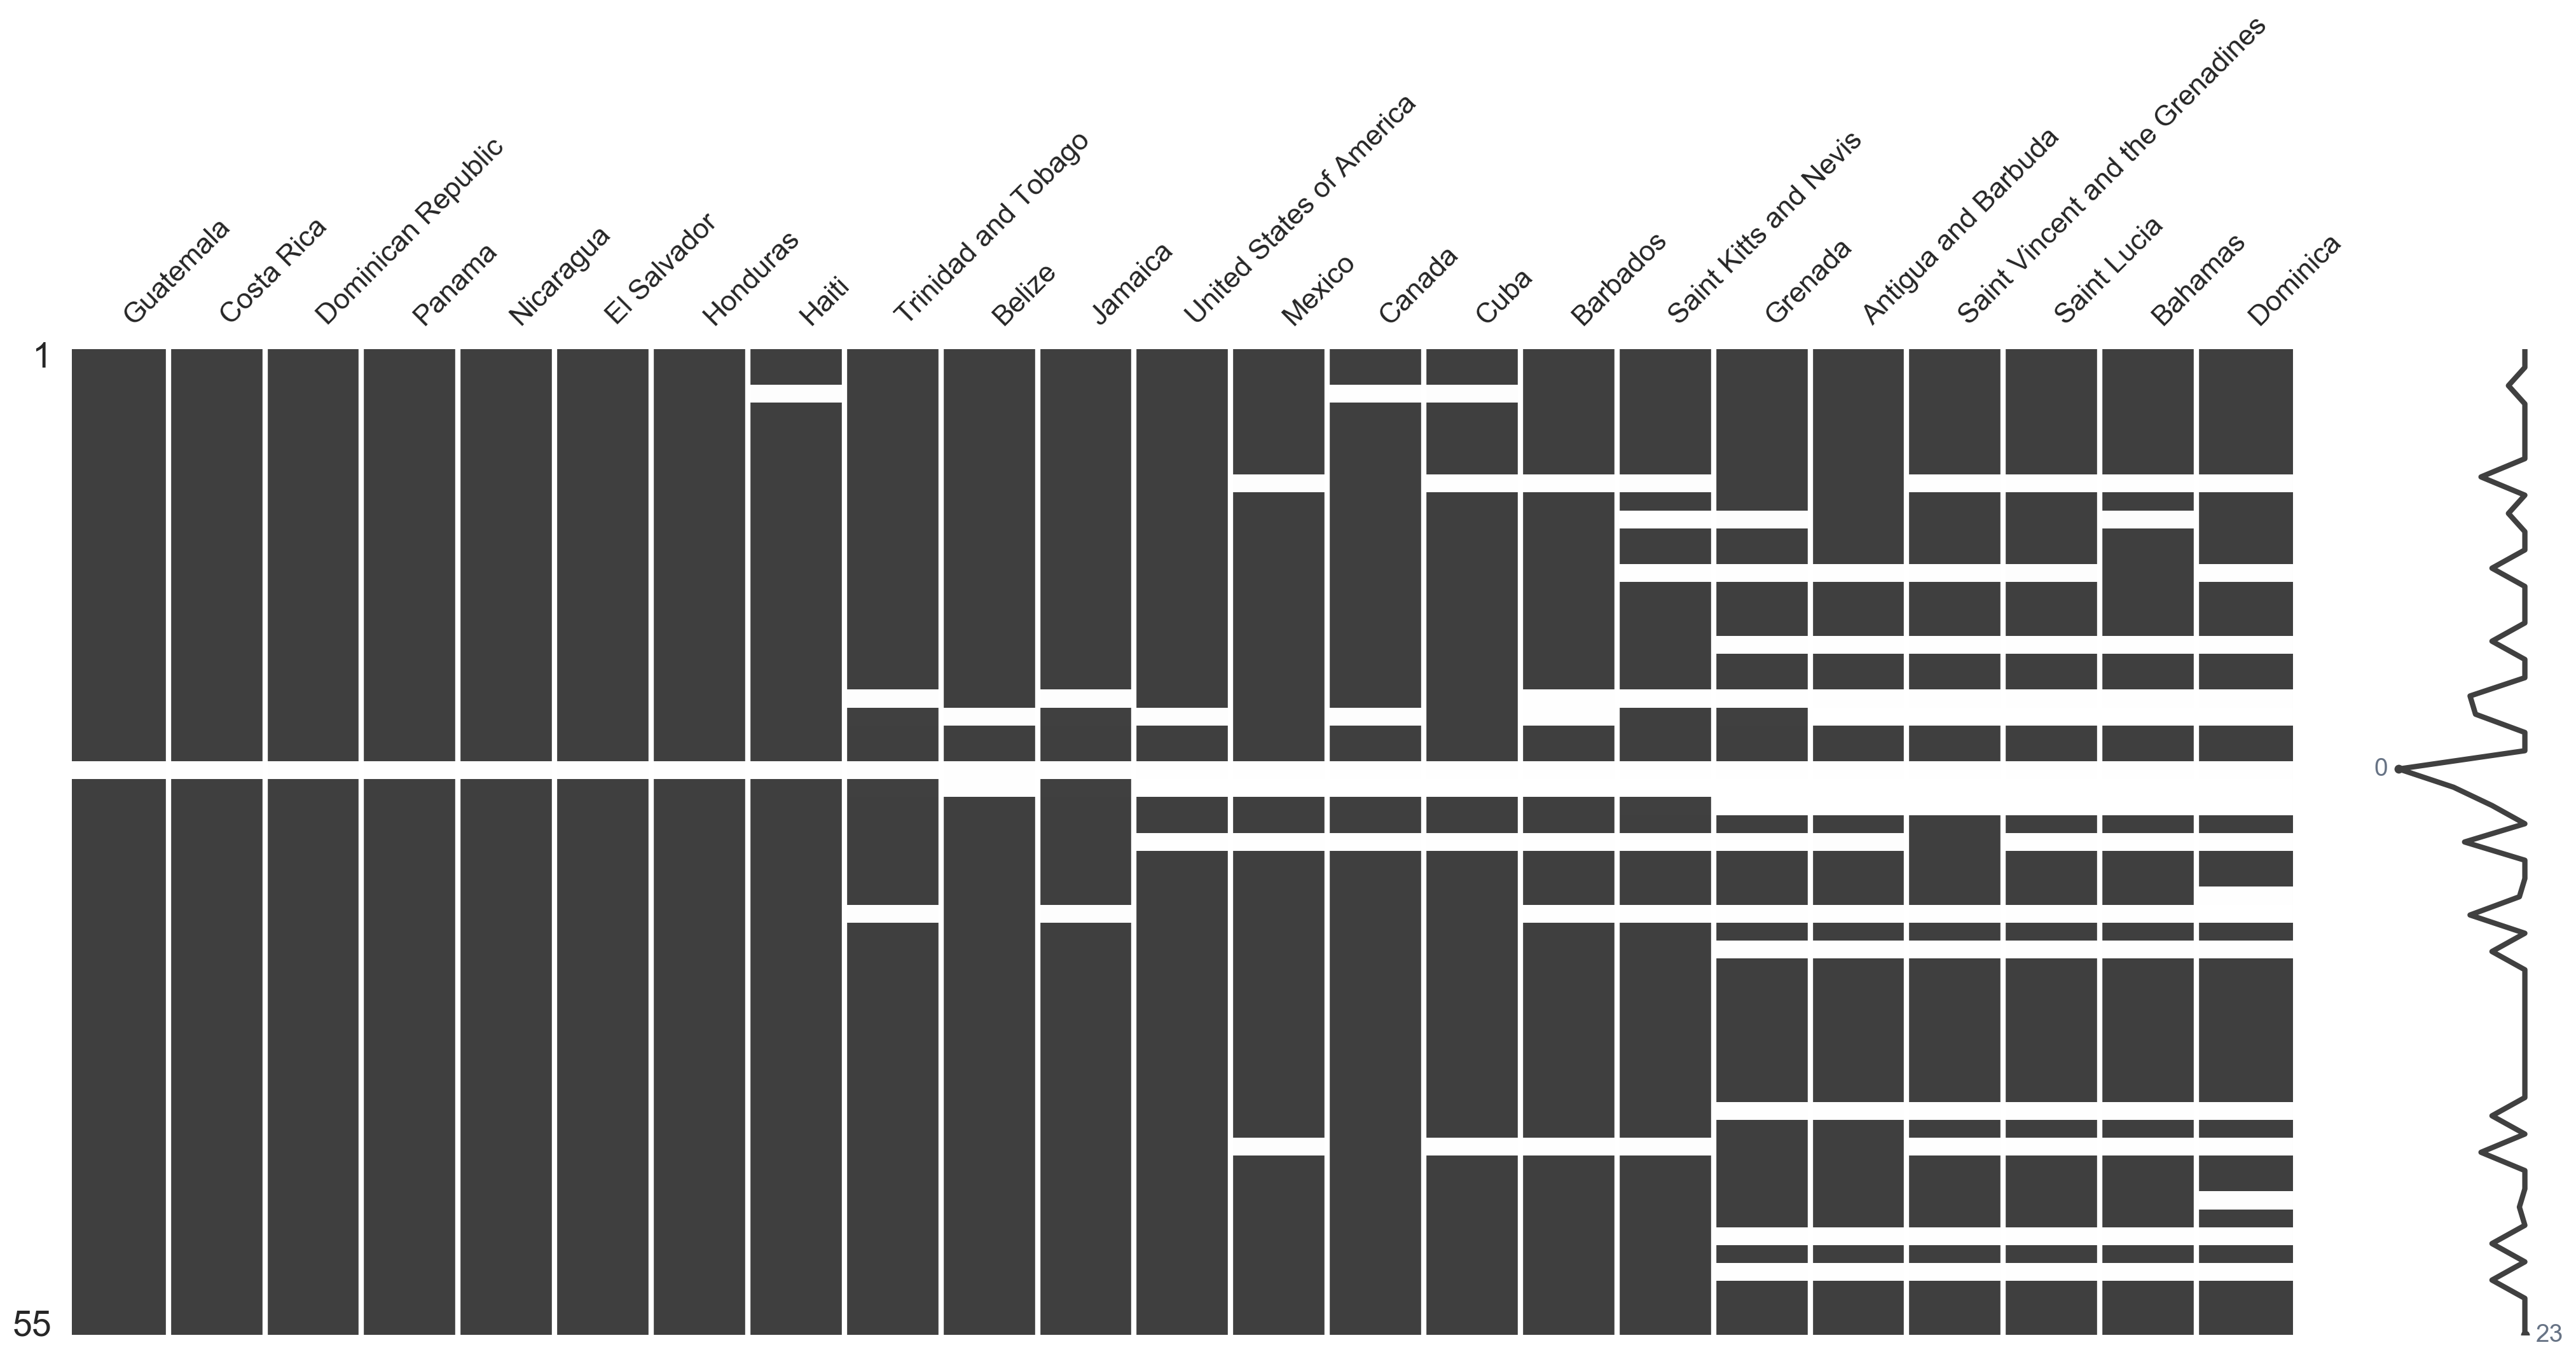

In [14]:
#指数完整性
msno.matrix(msno.nullity_sort(time_slice(north_america, '2013-2017'), sort='descending').T, inline=False)
#plt.title('Fraction of fields complete by country for North America \n \n');

抽查巴哈马缺少哪些数据以获得更多的了解 

In [16]:
msno.nullity_filter(country_slice(data, 'Bahamas').T, filter='bottom', p=0.1)

Bahamas      dam_capacity_per_capita  flood_occurence  gender_inequal_index  \
time_period                                                                   
1958-1962                        NaN              NaN                   NaN   
1963-1967                        NaN              NaN                   NaN   
1968-1972                        NaN              NaN                   NaN   
1973-1977                        NaN              NaN                   NaN   
1978-1982                        NaN              NaN                   NaN   
1983-1987                        NaN              NaN                   NaN   
1988-1992                        NaN              NaN                   NaN   
1993-1997                        NaN              NaN                   NaN   
1998-2002                        NaN              NaN                   NaN   
2003-2007                        NaN              NaN                   NaN   
2008-2012                        NaN              NaN                   NaN   
2013-2017                        NaN              NaN                0.2979   

Bahamas      groundwater_produced  interannual_variability  \
time_period                                                  
1958-1962                     NaN                      NaN   
1963-1967                     NaN                      NaN   
1968-1972                     NaN                      NaN   
1973-1977                     NaN                      NaN   
1978-1982                     NaN                      NaN   
1983-1987                     NaN                      NaN   
1988-1992                     NaN                      NaN   
1993-1997                     NaN                      NaN   
1998-2002                     NaN                      NaN   
2003-2007                     NaN                      NaN   
2008-2012                     NaN                      NaN   
2013-2017                     NaN                      NaN   

Bahamas      irrigation_potential  number_undernourished  \
time_period                                                
1958-1962                     NaN                    NaN   
1963-1967                     NaN                    NaN   
1968-1972                     NaN                    NaN   
1973-1977                     NaN                    NaN   
1978-1982                     NaN                    NaN   
1983-1987                     NaN                    NaN   
1988-1992                     NaN                    NaN   
1993-1997                     NaN                    NaN   
1998-2002                     NaN                    NaN   
2003-2007                     NaN                    NaN   
2008-2012                     NaN                    NaN   
2013-2017                     NaN                    NaN   

Bahamas      overlap_surface_groundwater  percent_undernourished  \
time_period                                                        
1958-1962                            NaN                     NaN   
1963-1967                            NaN                     NaN   
1968-1972                            NaN                     NaN   
1973-1977                            NaN                     NaN   
1978-1982                            NaN                     NaN   
1983-1987                            NaN                     NaN   
1988-1992                            NaN                     NaN   
1993-1997                            NaN                     NaN   
1998-2002                            NaN                     NaN   
2003-2007                            NaN                     NaN   
2008-2012                            NaN                     NaN   
2013-2017                            NaN                     NaN   

Bahamas      seasonal_variability  surface_groundwater_overlap  \
time_period                                                      
1958-1962                     NaN                          NaN   
1963-1967                     Na

### By country for a single variable

In [17]:
# JSON with coordinates for country boundaries 
geo = r'world.json'

null_data = recent['agg_to_gdp'].notnull()*1
map = folium.Map(location=[48, -102], zoom_start=2)
map.choropleth(geo_path=geo, 
               data=null_data,
               columns=['country', 'agg_to_gdp'],
               key_on='feature.properties.name', reset=True,
               fill_color='GnBu', fill_opacity=1, line_opacity=0.2,
               legend_name='Missing agricultural contribution to GDP data 2013-2017')
map

**Question:** 苍白的浅绿色意味着什么？和绿色相比？（例如格陵兰对加拿大）

Now let's functionalize so we can look at other variables geospatially.

In [18]:
def plot_null_map(df, time_period, variable, 
                  legend_name=None):
    geo = r'world.json'
    
    
    ts = time_slice(df, time_period).reset_index().copy()
    ts[variable]=ts[variable].notnull()*1
    map = folium.Map(location=[48, -102], zoom_start=2)
    map.choropleth(geo_path=geo, 
                   data=ts,
                   columns=['country', variable],
                   key_on='feature.properties.name', reset=True,
                   fill_color='GnBu', fill_opacity=1, line_opacity=0.2,
                   legend_name=legend_name if legend_name else variable)
    return map

In [19]:
plot_null_map(data, '2013-2017', 'number_undernourished', 'Number undernourished is missing')

**Question:** Are there any patterns in missing data? Any questions that come to mind for further investigation? 

### Over time

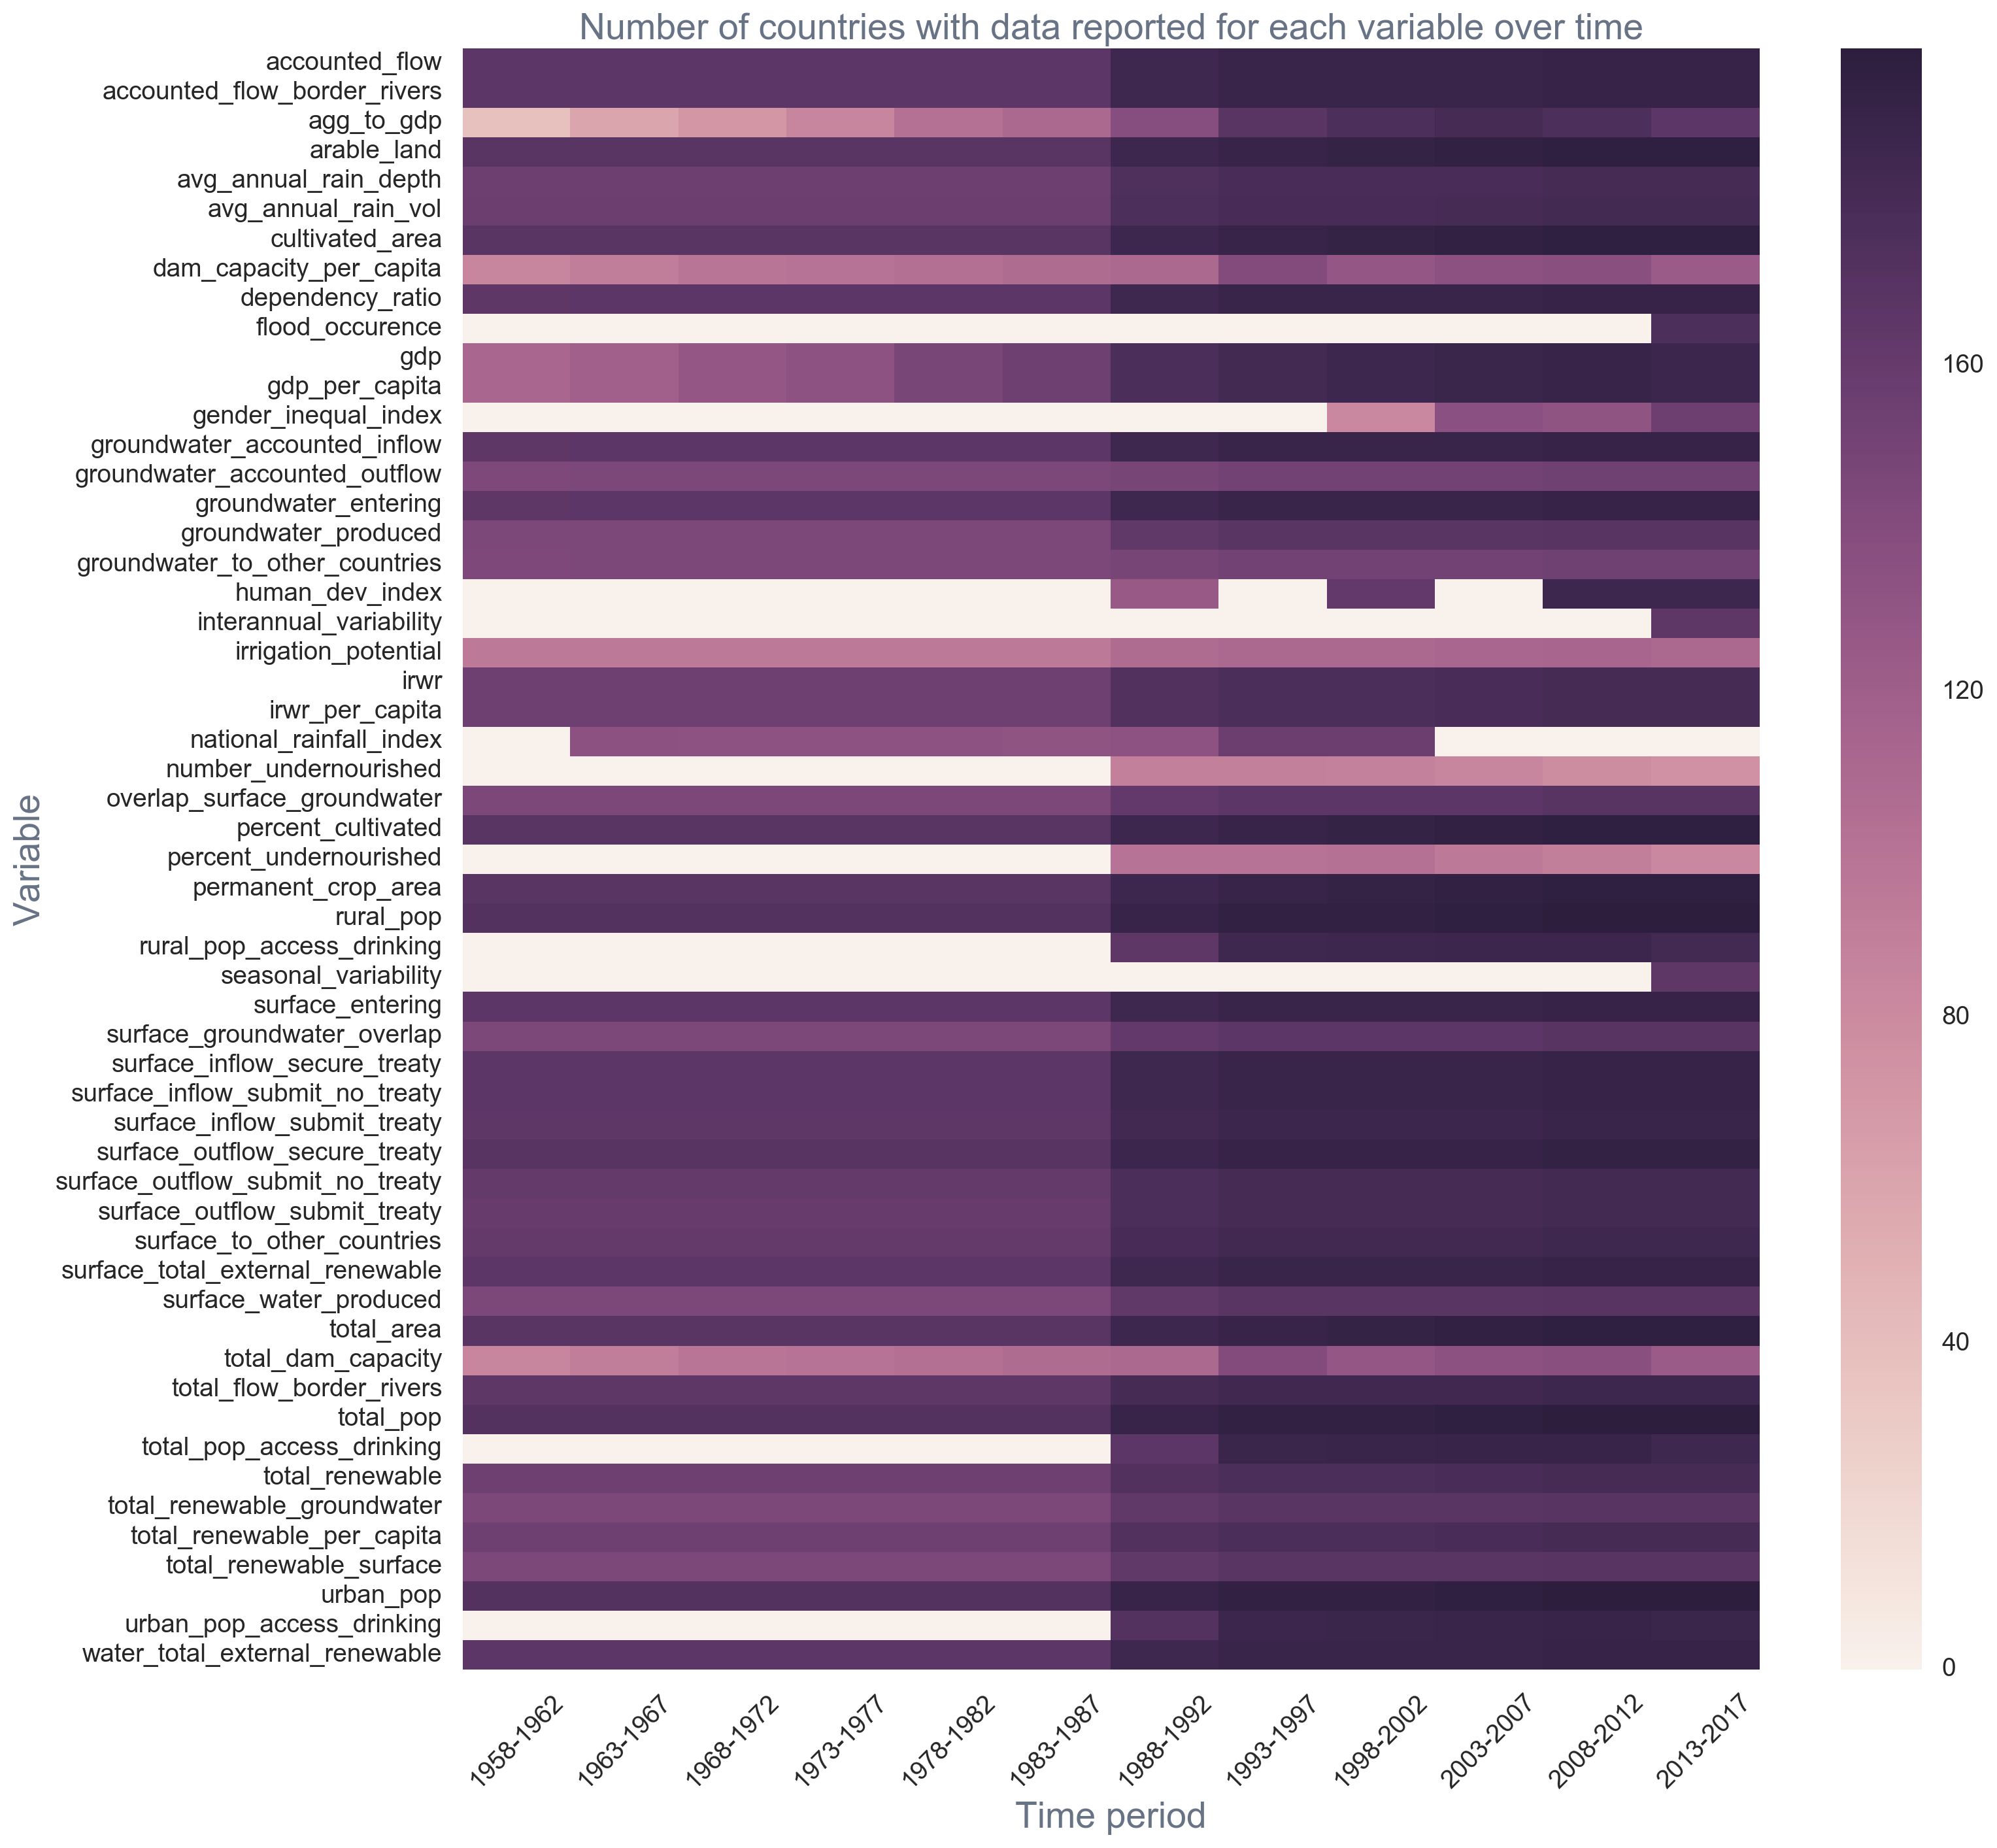

In [20]:
fig, ax = plt.subplots(figsize=(16, 16));
sns.heatmap(data.groupby(['time_period','variable']).value.count().unstack().T , ax=ax);
plt.xticks(rotation=45);
plt.xlabel('Time period');
plt.ylabel('Variable');
plt.title('Number of countries with data reported for each variable over time');

## Profiling 

### `pivottablejs`

In [23]:
#pivottablejs.pivot_ui(time_slice(data, '2013-2017'),)

### `pandas_profiling`

In [24]:
pandas_profiling.ProfileReport(time_slice(data, '2013-2017'))